This notebook cleans the outliers for Subject1, we can do the same for all the subjects.
The outliers may lead to overfitting or wrong predictions.

## Section 1: Importing Libraries and Setting Directories


In [3]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import sys
sys.path.append('../../../')
from pylab import rcParams

from numpy.random import normal, seed
from scipy.stats import norm

import math
from sklearn.metrics import mean_squared_error

from datetime import datetime
import cv2
import json
import matplotlib.colors as mcolors
import json

from PIL import Image
# Basic packages
import random as rd # generating random numbers
import seaborn as sns # for prettier plots

new_directory = '../'

target_directory = os.path.abspath(new_directory)

# Change the current directory to the target directory
os.chdir(target_directory)

In [7]:
import os
print(os.getcwd())


/usr/users/detectionpositionassise/ayat_may/Posture_detection/brouillon/md_clustering/Experiments/Posture_Data


## Section 2: Loading and Preprocessing Posture Data


In [8]:
folder_path=r'Data/Subject1/Postures'
filename1='Posture 1.json'
filename2='Posture 2.json'
filename3='Posture 3.json'
filename4='Posture 4.json'
filename5='Posture 5.json'
filename6='Posture 6.json'
filename7='Posture 7.json'

In [9]:
# Define kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
j=1
resultsfinal=[]
# Loop through all JSON files in directory
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        # Open the JSON file and read the data
        with open(os.path.join(folder_path, filename), 'r') as f:
            data = json.load(f)

        # Extract the pressure matrix data from the JSON data
        pressure_matrix = data['pressureData']
        print(len(pressure_matrix))
        date_str = pressure_matrix[0]['dateTime']
        date_str_truncated = date_str[:26] + date_str[26:].replace(date_str[26:], '')
        try:
            start_timestamp = datetime.fromisoformat(date_str_truncated).timestamp()
            end_timestamp = start_timestamp + 20

            # Collect samples at a rate of 50Hz
            sample_rate = 50
            sample_interval = 1 / sample_rate
            results = []
            for matrix in pressure_matrix:
                date_str = matrix['dateTime']
                date_str_truncated = date_str[:26] + date_str[26:].replace(date_str[26:], '')
                try:
                    timestamp = datetime.fromisoformat(date_str_truncated).timestamp()

                    if timestamp < start_timestamp or timestamp > end_timestamp:
                        continue
                    if not results:
                        last_sample_time = start_timestamp
                    else:
                        last_sample_time = results[-1]['timestamp']
                    if timestamp - last_sample_time >= sample_interval:
                      if len(results)<502:
                        results.append({
                            'timestamp': timestamp,
                            'matrix': np.array(matrix['pressureMatrix'])
                        })
                except ValueError:
                    pass

            # Print the number of samples collected and the sample rate
            print(f"Number of samples collected: {len(results)}")
            print(f"Sample rate: {sample_rate}Hz")
            i=0

            # Perform operations on each sample in results
            for pressuremat in results:
                pressure_values = pressuremat['matrix']
                i+=1
                # Create binary mask array by thresholding
                threshold_value = 0.45 * np.mean(pressure_values)
                binary_mask = np.where(pressure_values >= threshold_value, 1, 0)
                #plt.imshow(binary_mask, cmap='jet', extent=[0, 16, 0, 16])

                #plt.show()

                # Apply opening operation
                opened = cv2.morphologyEx(binary_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)

                # Apply closing operation
                closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

                filtered_pressure = cv2.GaussianBlur(pressure_values, (3, 3), 0)

                preprocessed_array = binary_mask * filtered_pressure


                sum_values = np.sum(preprocessed_array)
                normalized_data = preprocessed_array / sum_values
                pressuremat['matrix'] = normalized_data

        except ValueError:

            print("Invalid timestamp format in data")
        j+=1
        resultsfinal.append(results)

## Data Visualization and Analysis

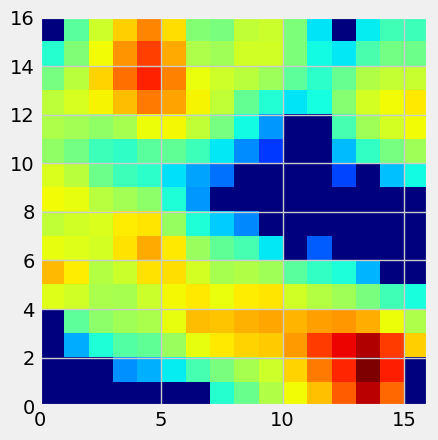

In [ ]:
plt.imshow(normalized_data, cmap='jet', extent=[0, 16, 0, 16])

In [ ]:
l=[]
for posture in resultsfinal:
  l1=[]
  for pressure in posture :
    l1.append(pressure['matrix'])
  l.append(l1)

<Figure size 1200x800 with 0 Axes>

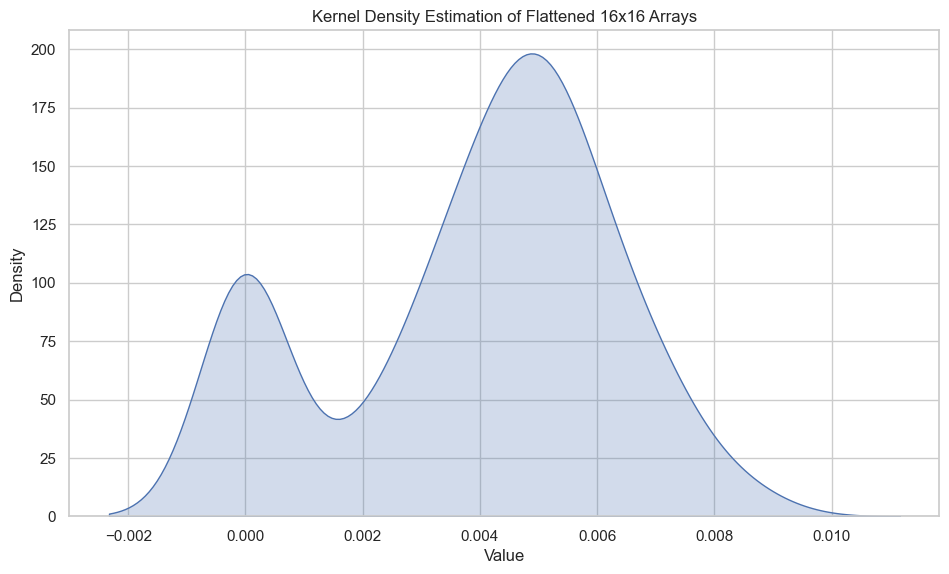

In [ ]:
random_seed = 1
np.random.seed(random_seed)
# Randomly choose 16 sensor indices


# Create a single graph with KDE plots for the selected sensors
plt.figure(figsize=(12, 8))
idx=1
sensor_values = []
# Flatten the arrays and create a single list of flattened arrays
flattened_arrays = [arr.flatten() for arr in l1[0]]

# Convert the list of flattened arrays into a single array
data = np.concatenate(flattened_arrays)

# Create a KDE plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, cmap="Blues", shade=True)

plt.title("Kernel Density Estimation of Flattened 16x16 Arrays")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()






In [ ]:
posture_labels = [0, 1, 2, 3, 4,5,6]
combined_data = [array for posture in l for array in posture]
labels = [posture_label for posture_label, posture_arrays in enumerate(l) for _ in posture_arrays]


In [ ]:
# Convert the data and labels to arrays
X = np.array(combined_data)
y = np.array(labels)
X = X.reshape(X.shape[0], -1)

print("Data Shape:", X.shape)
print("Labels Shape:", y.shape)

Data Shape: (2378, 256)
Labels Shape: (2378,)


### t-SNE Visualization of the 7 postures data 

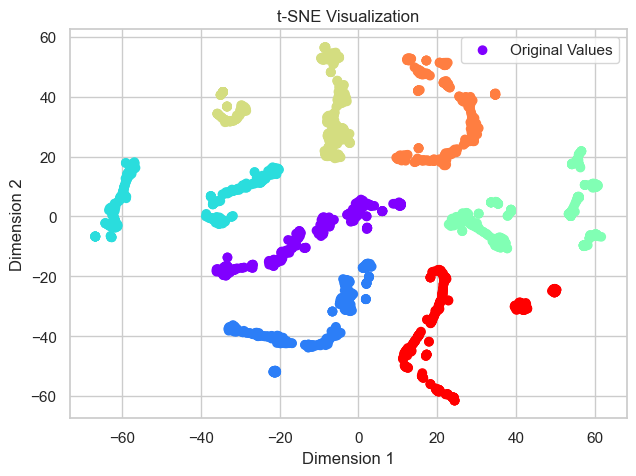

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

reshaped_data = np.array([data.flatten() for data in combined_data])

original_data_tsne = tsne.fit_transform(reshaped_data)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1], c=y,cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

## Outlier Removal and Visualization

In [ ]:
data_posture1=[array.flatten() for array in l[0]]

sensor_values=[]
for sample in data_posture1 :
    for i in range(len(sample)) : 
        
        sensor_values.append(sample[i])
filtered_postures=[]
for i in range(len(l)):
  data_posture1=[array.flatten() for array in l[i]]

  sensors_specfic=[]
  for sensidx in range(256):

    sensor_values=[]
    for sample in data_posture1 :
        sensor_values.append(sample[sensidx])
    data=sensor_values
    # Calculate the interquartile range
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 0.1 * iqr
    upper_bound = q3 + 0.1 * iqr

    # Remove outliers and create a new list without outliers
    filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
    sensors_specfic.append(filtered_values)

    N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
    min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
    new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
    for i in range(min_length):
      for sensor_values in sensors_specfic:
          new_sensor_data[i].append(sensor_values[i])
  #new data posture list of number of samples*256





  filtered_postures.append(new_sensor_data)


In [ ]:
combined_data = [array for posture in filtered_postures for array in posture]
labels = [posture_label for posture_label, posture_arrays in enumerate(filtered_postures) for _ in posture_arrays]


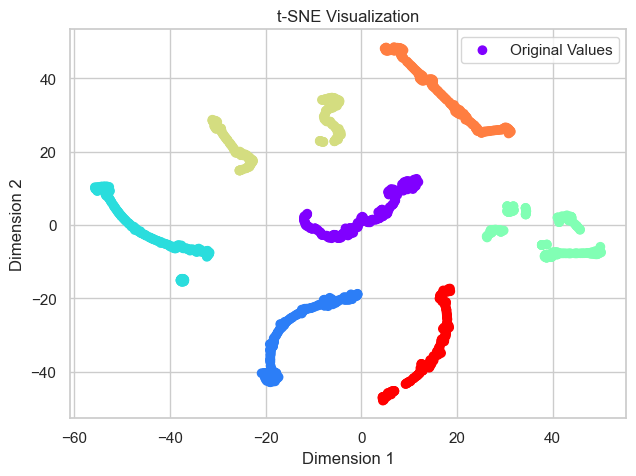

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(combined_data)
y = np.array(labels)
original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1], c=y,cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

### Some more Outlier Removal

In [ ]:

data_posture1=[array.flatten() for array in l[0]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.5 * iqr
  upper_bound = q3 + 0.5 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256





Posture1_filtered=new_sensor_data

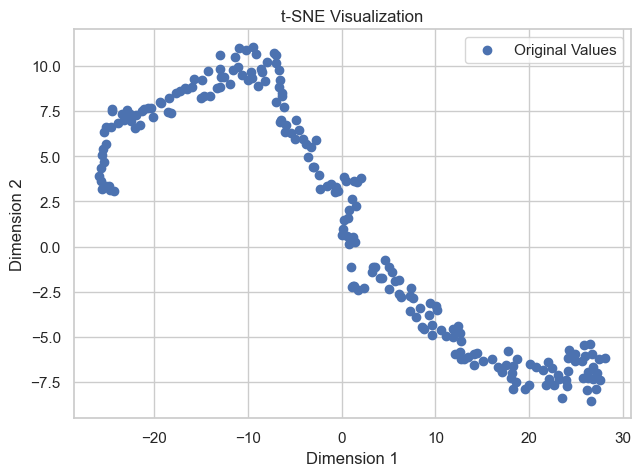

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[1]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.1 * iqr
  upper_bound = q3 + 0.1 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256


Posture2_filtered=new_sensor_data




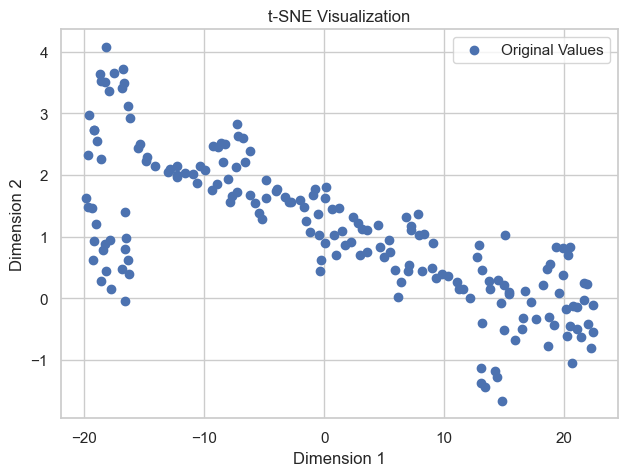

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[2]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.03 * iqr
  upper_bound = q3 + 0.03 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])





Posture3_filtered=new_sensor_data



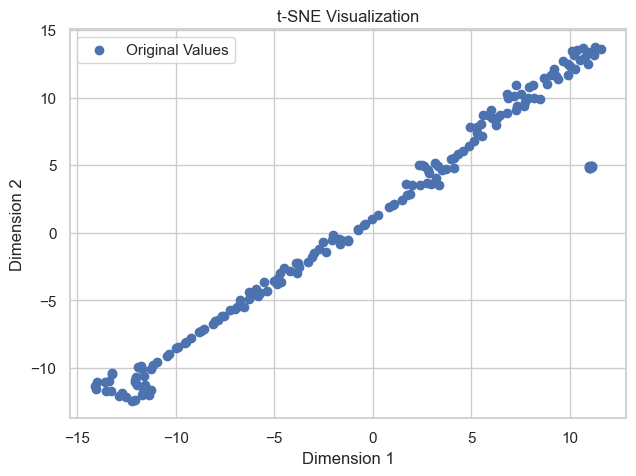

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[3]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.5 * iqr
  upper_bound = q3 + 0.5 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])



# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256







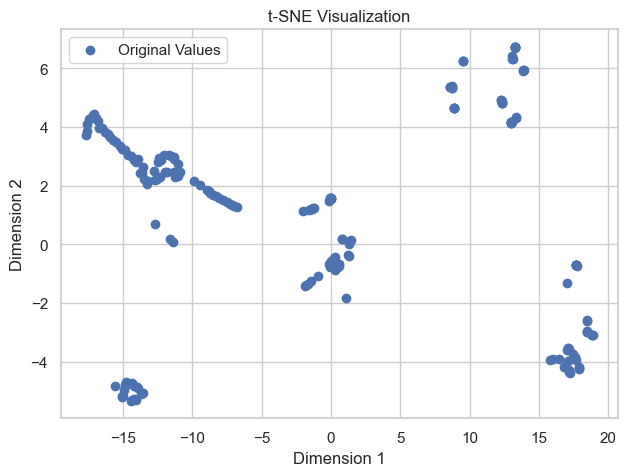

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

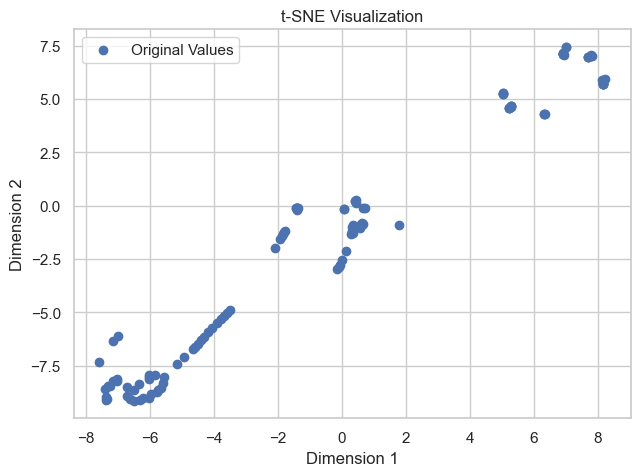

In [ ]:
# Calculate distances from the cluster center
cluster_center = np.mean(original_data_tsne, axis=0)
distances = np.linalg.norm(original_data_tsne - cluster_center, axis=1)


threshold = np.percentile(distances, 60)

# Identify and remove outliers
outliers_indices = np.where(distances > threshold)[0]
Posture4_filtered = np.array([sublist for sublist, distance in zip(new_sensor_data, distances) if distance <= threshold])

original_data_tsne = tsne.fit_transform(Posture4_filtered)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[4]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.3 * iqr
  upper_bound = q3 + 0.3 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256



Posture5_filtered=new_sensor_data




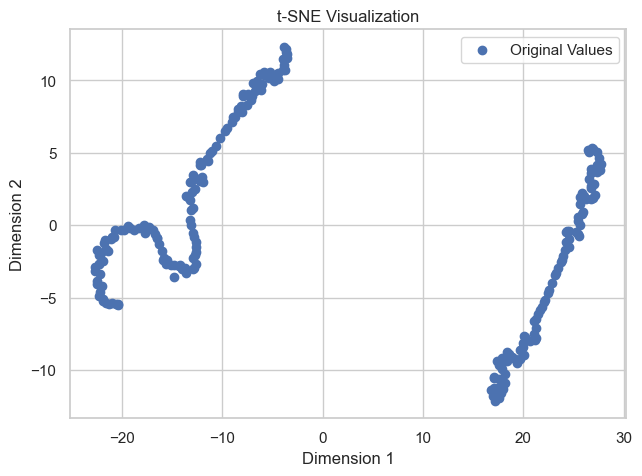

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[5]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.00001 * iqr
  upper_bound = q3 + 0.00001 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256







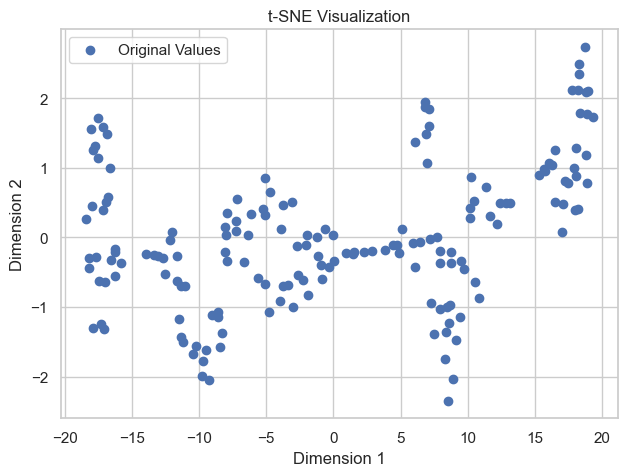

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

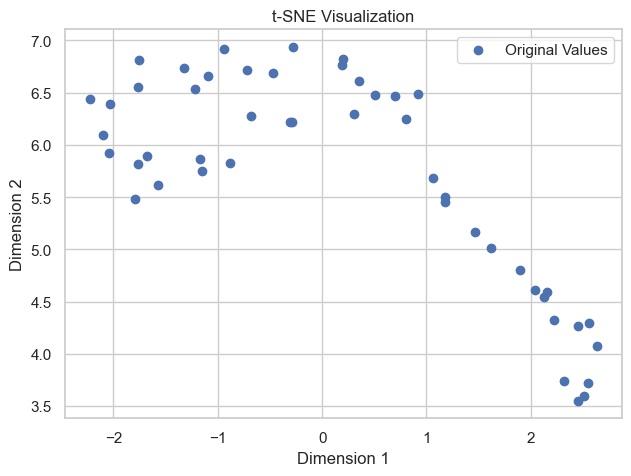

In [ ]:
# Calculate distances from the cluster center
cluster_center = np.mean(original_data_tsne, axis=0)
distances = np.linalg.norm(original_data_tsne - cluster_center, axis=1)

threshold = np.percentile(distances, 28)

# Identify and remove outliers
outliers_indices = np.where(distances > threshold)[0]
Posture6_filtered = np.array([sublist for sublist, distance in zip(new_sensor_data, distances) if distance <= threshold])

original_data_tsne = tsne.fit_transform(Posture6_filtered)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:

data_posture1=[array.flatten() for array in l[6]]

sensors_specfic=[]
for sensidx in range(256):

  sensor_values=[]
  for sample in data_posture1 :
      sensor_values.append(sample[sensidx])
  data=sensor_values
  # Calculate the interquartile range
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1

  # Define the lower and upper bounds for outliers
  lower_bound = q1 - 0.1 * iqr
  upper_bound = q3 + 0.1 * iqr

  # Remove outliers and create a new list without outliers
  filtered_values = [value for value in data if lower_bound <= value <= upper_bound]
  sensors_specfic.append(filtered_values)

  N_samples = len(sensors_specfic[0])

# Initialize the new list of lists


# Find the minimum length among all sublists
  min_length = min(len(sublist) for sublist in sensors_specfic)

# Initialize the new list of lists
  new_sensor_data = [[] for _ in range(min_length)]

# Iterate through each sensor sublist and append its values to the corresponding new_sensor_data sublist
  for i in range(min_length):
    for sensor_values in sensors_specfic:
        new_sensor_data[i].append(sensor_values[i])
#new data posture list of number of samples*256







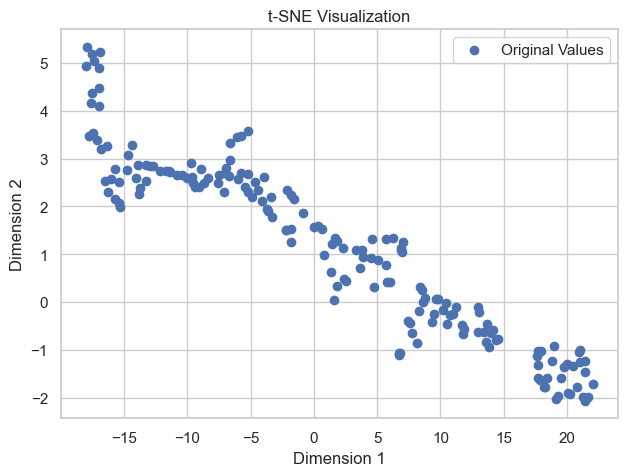

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(new_sensor_data)

original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

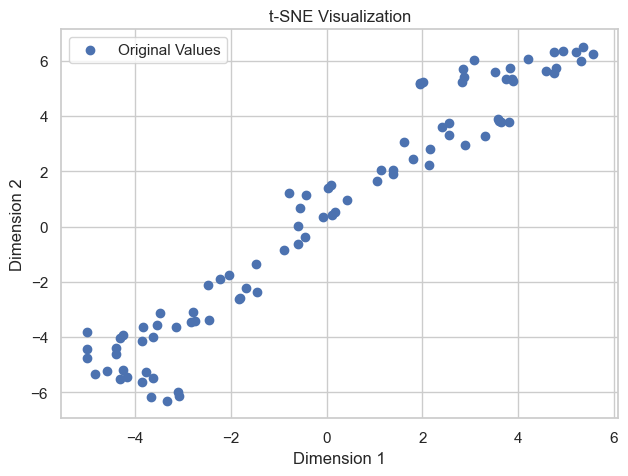

In [ ]:
# Calculate distances from the cluster center
cluster_center = np.mean(original_data_tsne, axis=0)
distances = np.linalg.norm(original_data_tsne - cluster_center, axis=1)

threshold = np.percentile(distances, 50)

# Identify and remove outliers
outliers_indices = np.where(distances > threshold)[0]
Posture7_filtered = np.array([sublist for sublist, distance in zip(new_sensor_data, distances) if distance <= threshold])

original_data_tsne = tsne.fit_transform(Posture7_filtered)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1],cmap='rainbow',label='Original Values')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
l=[Posture1_filtered,Posture2_filtered,Posture3_filtered,Posture4_filtered,Posture5_filtered,Posture6_filtered,Posture7_filtered]

In [ ]:
labels = [posture_label for posture_label, posture_arrays in enumerate(l) for _ in posture_arrays]
combined_data = [array for posture in l for array in posture]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


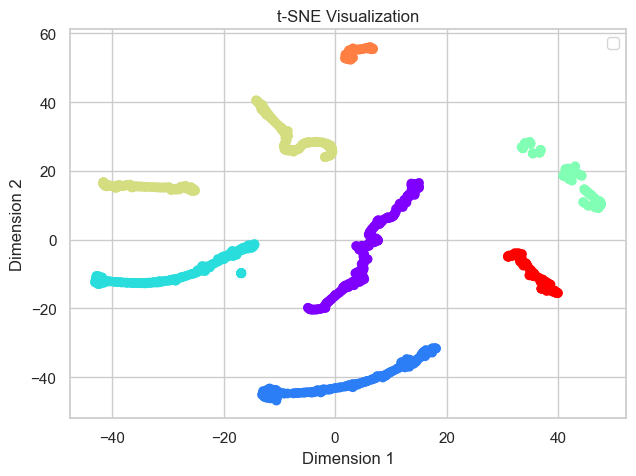

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X = np.array(combined_data)
y = np.array(labels)
original_data_tsne = tsne.fit_transform(X)

plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1], c=y,cmap='rainbow')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [ ]:
#np.save('CleanSubject1data_list', l)
print(l)

[[[0.004330688442985248, 0.004866366750772403, 0.006193177180813847, 0.006934552632111036, 0.006336609878798544, 0.005485728947260168, 0.004861791695975959, 0.004655495428459555, 0.004971380611615615, 0.00469228263721761, 0.004047885201581728, 0.004059141051985848, 0.004582264196475214, 0.004833347166145088, 0.004171136488312941, 0.0035995569561577587, 0.004711980375424821, 0.005331179208401087, 0.006812676871600906, 0.0077879502212628475, 0.007133864876206463, 0.0059096388608257736, 0.005151368177110342, 0.004900524173965468, 0.005083732683121436, 0.004789364346953147, 0.004243455602353317, 0.004426782735547331, 0.004992366380269342, 0.005114420601636642, 0.004506416677296652, 0.0040270523161472956, 0.005295089779640659, 0.005810129280476798, 0.007182384755276829, 0.008332479238523928, 0.00790522374899015, 0.0064671626403633425, 0.0055807994819723015, 0.005188679245283019, 0.004872918639437541, 0.004606682033940068, 0.004532482323318939, 0.005035476268645168, 0.005638422970247891, 0.0

### Random Clustering Example

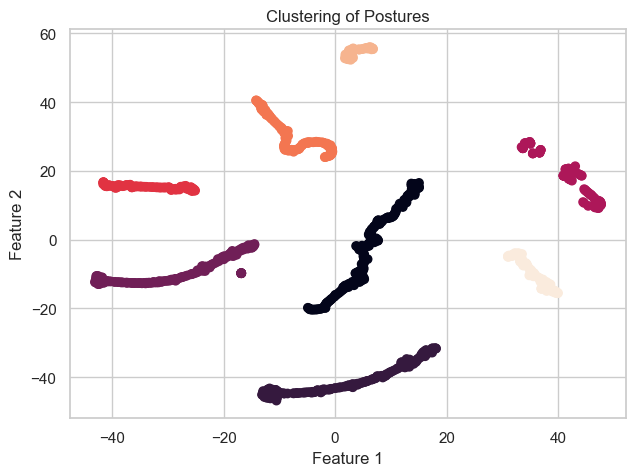

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=10, min_samples=5)
labels = dbscan.fit_predict(original_data_tsne)

# Visualize clusters (2D example)
plt.scatter(original_data_tsne[:, 0], original_data_tsne[:, 1], c=labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering of Postures')
plt.show()